In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.pipeline import Pipeline
from scipy.stats import rankdata


from typing import List, Optional
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import statsmodels.api as sm
from tqdm import tqdm
import lightgbm as lgb
import catboost as cb
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import sklearn as sk
from sklearn.metrics import roc_auc_score, f1_score,r2_score,classification_report,accuracy_score,precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
# import missingno as msno
# import xgboost as xgb
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import ttest_rel
%matplotlib inline

In [3]:
TRAIN = 'course_project_train.csv'
TEST = 'course_project_test.csv'
Train_working="Train_working.csv"
Test_working ='Test_working.csv'
predict = 'VErshov_predictions.csv'
Train_work = 'Train_work.pkl'
Test_work = 'Test_work.pkl'


In [4]:
train = pd.read_csv(Train_working)
test= pd.read_csv(Test_working)
target = train['Credit Default']
with open(Train_work, 'rb') as f:
    train_work = pickle.load(f)
with open(Test_work, 'rb') as f:
    test_work = pickle.load(f)

train_ = pd.read_csv(TRAIN)    

In [5]:
# разделим признаки по типу
target_col = ['Credit Default']
categorical_features=['Home Ownership','Tax Liens','Purpose','Term']
discrete_feature = ['Years in current job','Number of Open Accounts',\
                    'Years of Credit History','Number of Credit Problems',\
                   'Months since last delinquent','Bankruptcies','Credit Score']
continuous_feature = ['Annual Income','Maximum Open Credit','Current Loan Amount',\
                      'Current Credit Balance','Monthly Debt']
len(target_col + categorical_features +  discrete_feature + continuous_feature)

17

In [6]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) :
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [7]:
def test_hold_out_val(df,target,params,n=500):
    res = pd.DataFrame()
    for j in [0.2,0.25,0.3,0.35]:
        score={}
        score['test'] = []
        score['train'] = []   
        for i in range(n):      
            x_train, x_test,y_train,y_test = train_test_split(df,target, test_size=j,\
                                                              shuffle=True, random_state=i+1)
            dtrain = lgb.Dataset(data = x_train,label=y_train)
            dvalid = lgb.Dataset(data=x_test,label=y_test)
            model_lgb  = lgb.train(
                    params=params,
                    train_set=dtrain,
                    num_boost_round=10000,
                    valid_sets=[dtrain, dvalid],
                    categorical_feature='auto',
                    verbose_eval=None,
                    early_stopping_rounds=95)
            score['train'].append(model_lgb.best_score['training']['auc'])
            score['test'].append(model_lgb.best_score['valid_1']['auc'])
        test = np.array(score['test'])
        train = np.array(score['train'])
        res.loc[j,'conf_v']=str(calculate_confidence_interval(test))
        res.loc[j,'min_v']=test.min()
        res.loc[j,'max_v']=test.max()
        res.loc[j,'delta_v']=test.max() - test.min()
        res.loc[j,'mean_v']=test.mean()
        res.loc[j,'std_v']=test.std()
        res.loc[j,'delta_mean_v_t']=train.mean()-test.mean()
        res.loc[j,'conf_t']=str(calculate_confidence_interval(train))
        res.loc[j,'min_t']=train.min()
        res.loc[j,'max_t']=train.max()
        res.loc[j,'delta_t']=train.max() - train.min()
        res.loc[j,'mean_t']=train.mean()
        res.loc[j,'std_t']=train.std()
    return res  

def test_hold_out_val_1(df,target,params,n=100):
    res = pd.DataFrame()

    score={}
    score['test'] = []
    score['valid'] = []   
    for i in range(n):      
        x_train, x_valid,y_train,y_valid = train_test_split(df,target, test_size=0.3,\
                                                              shuffle=True, random_state=i+1)
        x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=i+1)
            
            
            
            
        dtrain = lgb.Dataset(data = x_train,label=y_train)
        dvalid = lgb.Dataset(data=x_valid,label=y_valid)
        model_lgb  = lgb.train(
                    params=params_lgb,
                    train_set=dtrain,
                    num_boost_round=10000,
                    valid_sets=[dtrain, dvalid],
                    categorical_feature='auto',
                    verbose_eval=None,
                    early_stopping_rounds=95)
        a=roc_auc_score(y_test,model_lgb.predict(x_test))
        b=model_lgb.best_score['valid_1']['auc']
        score['test'].append(a)
        score['valid'].append(b)
    test = np.array(score['test'])
    valid = np.array(score['valid'])
    res.loc[0,'conf_t']=str(calculate_confidence_interval(test))
    res.loc[0,'min_t']=test.min()
    res.loc[0,'max_t']=test.max()
    res.loc[0,'delta_t']=test.max() - test.min()
    res.loc[0,'mean_t']=test.mean()
    res.loc[0,'std_t']=test.std()
    res.loc[0,'delta_mean_v_t']=valid.mean()-test.mean()
    res.loc[0,'conf_v']=str(calculate_confidence_interval(valid))
    res.loc[0,'min_v']=valid.min()
    res.loc[0,'max_v']=valid.max()
    res.loc[0,'delta_v']=valid.max() - valid.min()
    res.loc[0,'mean_v']=valid.mean()
    res.loc[0,'std_v']=valid.std()
    return res  




def test_cros_val(df,target,model,metric,n=100):
    res = pd.DataFrame()
    for j in [3,4,5,6,7,8]:
        score=[]
        std = []
 
        for i in range(n):
            cv_strategy = KFold(n_splits=j, shuffle=True, random_state=i+1)        
            rusult= make_cross_validation(df, target, model, metric,cv_strategy,print_is=False)
            
            score.append(rusult[1])
            std.append(np.array(rusult[3]).std())

        test = np.array(score)
        train = np.array(std)

        res.loc[j,'conf_of']=str(calculate_confidence_interval(test))
        res.loc[j,'min_of']=test.min()
        res.loc[j,'max_of']=test.max()
        res.loc[j,'delta_of']=test.max() - test.min()
        res.loc[j,'mean_of']=test.mean()
        res.loc[j,'std_of'] = test.std()
        res.loc[j,'conf_st']=str(calculate_confidence_interval(train))
        res.loc[j,'min_st']=train.min()
        res.loc[j,'max_st']=train.max()
        res.loc[j,'delta_st']=train.max() - train.min()
        res.loc[j,'mean_st']=train.mean()
        res.loc[j,'std_st']=train.std()
    return res
        

In [8]:
def drop_target(df,target='Credit Default'):
    return df.drop(target,axis = 1)

In [15]:
def test_for_data(        y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy: int,
                          data: list):
    p,t_stats, n_trees,off_n = [], [],[],[]
    base_score = np.array([])
    for num,i in enumerate(data):
        current_score = np.array([])
        off = []
        
        for j in range(20):
            fold = KFold(n_splits=cv_strategy, shuffle=True, random_state=j+1)
            res = make_cross_validation(i,y,estimator,metric,fold,print_is=False)
            scores = res[3]
            off.append(res[1])
            if num == 0:
                base_score = np.append(base_score, scores)
            else:
                current_score = np.append(current_score, scores)
        if num!=0:
            t_stat, p_value = ttest_rel(current_score, base_score)
            t_stats.append(t_stat)
            n_trees.append(num)
            p.append(p_value)
        off_n.append(off)

    plt.plot(n_trees, t_stats)
    plt.xlabel('data')
    plt.ylabel('t-statistic')
    return (t_stats,p),off_n
        
        
def make_cross_validation_cb(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,print_is = True):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train) 

        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if print_is:
            print(msg)
            print("="*69)
        estimators.append(estimator)
    oof_score = metric(y, oof_predictions)
    if print_is:
        print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
        print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
        print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions        
    
    



In [10]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [11]:
train[categorical_features] =train[categorical_features].astype('str')
test[categorical_features] =test[categorical_features].astype('str')


In [12]:
train_work.keys()

dict_keys(['start', '1', '2', '3', '1-1', '1-2', '1-3', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4', '5', '6', '4-2', '5-2', '6-2'])

In [13]:
for i in train_work:
    a = categorical_features.copy()
    a.remove('Purpose')
    a.remove( 'Tax Liens')
    if i in ['4-2','5-2','6-2']:
        continue
    train_work[i][categorical_features] =train_work[i][categorical_features].astype('str')
    test_work[i][categorical_features] =train_work[i][categorical_features].astype('str')

In [168]:
param_cb = {
    "n_estimators": 800,
    "loss_function": "Logloss",
    
#     "loss_function": 'CrossEntropy',
    "eval_metric": "AUC",
    "task_type": "CPU",
    "thread_count": -1,
    "early_stopping_rounds": 90,
    'custom_metric':  ['AUC'],
#     'cat_features' : categorical_features,
    "verbose": False,
    "random_seed": 42,
    "max_bin": 30,
    'learning_rate':0.05,
    "max_depth": 2,
    "l2_leaf_reg": 28, 
#     'random_strength':150,
#     'bagging_temperature':500,
    
    
    
    }
model_cb = cb.CatBoostClassifier(**param_cb)


Крос валидация

In [164]:
X_train = drop_target(train_work['3-3']).copy()

In [165]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=100)

In [166]:
%%time
res = make_cross_validation_cb(
    X_train, target, model_cb, metric=roc_auc_score, cv_strategy=cv_strategy
            )

Fold: 1, train-observations = 6000, valid-observations = 1500
train-score = 0.8231, valid-score = 0.785
Fold: 2, train-observations = 6000, valid-observations = 1500
train-score = 0.8282, valid-score = 0.7794
Fold: 3, train-observations = 6000, valid-observations = 1500
train-score = 0.8233, valid-score = 0.7842
Fold: 4, train-observations = 6000, valid-observations = 1500
train-score = 0.8281, valid-score = 0.7835
Fold: 5, train-observations = 6000, valid-observations = 1500
train-score = 0.8296, valid-score = 0.7589
CV-results train: 0.8265 +/- 0.003
CV-results valid: 0.7782 +/- 0.01
OOF-score = 0.7777
Wall time: 8.4 s


Крос валидация на разных рандомах

In [70]:
%%time
n = 100
res_all=[]
for i in tqdm(range(n)):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    res = make_cross_validation_cb(
    X_train, target, model_cb, metric=roc_auc_score,\
        cv_strategy=fold,print_is=False
            )
    res_all.append(res[1])
a = np.array(res_all) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [22:09<00:00, 13.29s/it]

0.7753980542982173 0.0014265587871641445 0.7789236168367679 0.7724749007948971
Wall time: 22min 9s


In [28]:
model_cb.fit(x_trainain,target)

<BarContainer object of 16 artists>

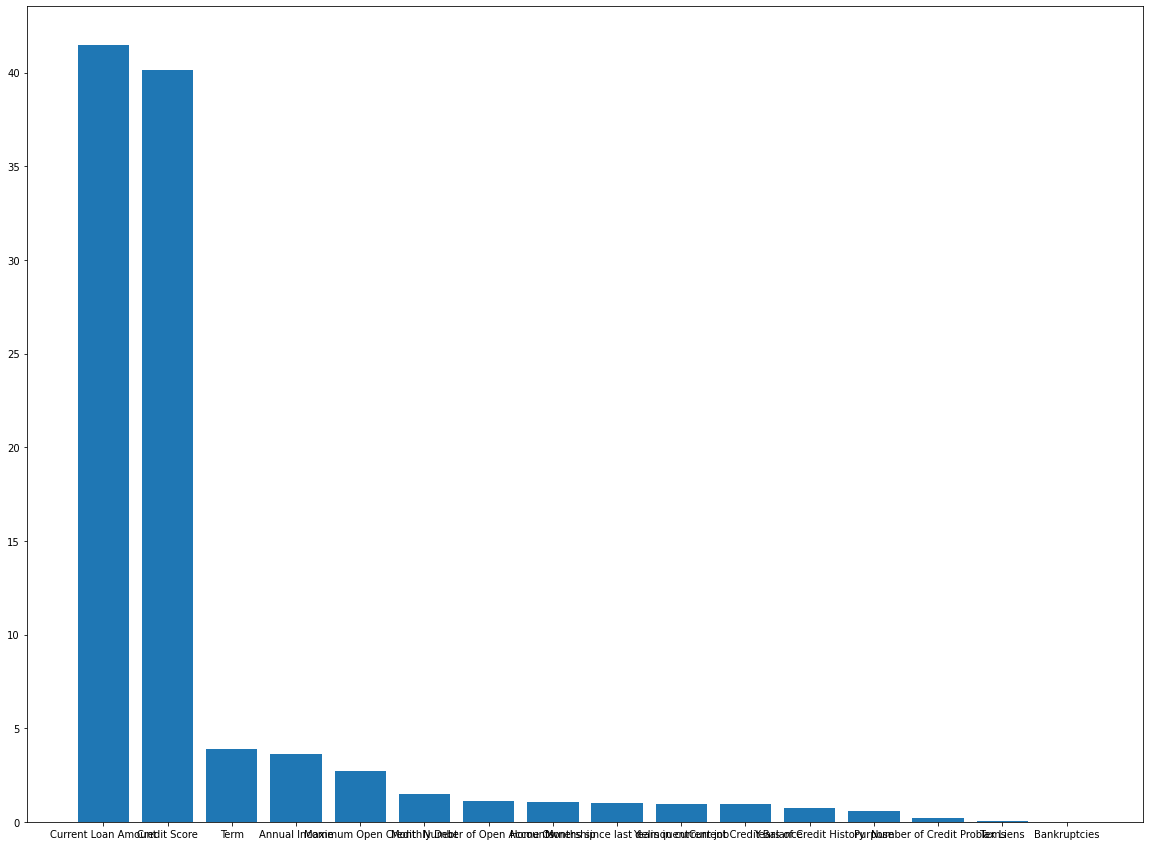

In [31]:
model_cb.feature_importances_
d = list(zip(test.columns.to_list(),model_cb.feature_importances_))
x = list(map(lambda x:x[0],(sorted(d,key = lambda x: x[1],reverse=True))))
y = list(map(lambda x:x[1],(sorted(d,key = lambda x: x[1],reverse=True))))
fig = plt.figure(figsize=(20,15))
plt.bar(x,y)


In [ ]:
importance = x[:-3]
importance

Сравним наборы данных по фолдам крос валидации

Балансировка признаков

In [80]:
x_train, x_valid,y_train,y_valid = train_test_split(train_work['3-3'],target, test_size=0.3,\
                                                              shuffle=True, random_state=89)


In [81]:
x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=89)

In [83]:
train_balanced = balance_df_by_target(x_train, target_col[0])


In [84]:
target_balanced = train_balanced[target_col[0]]

In [85]:
res_ = make_cross_validation_cb(
    drop_target(train_balanced), target_balanced, model_cb, metric=roc_auc_score, cv_strategy=cv_strategy
            )

Fold: 1, train-observations = 5353, valid-observations = 1339
train-score = 0.8321, valid-score = 0.8006
Fold: 2, train-observations = 5353, valid-observations = 1339
train-score = 0.8267, valid-score = 0.8003
Fold: 3, train-observations = 5354, valid-observations = 1338
train-score = 0.8348, valid-score = 0.7921
Fold: 4, train-observations = 5354, valid-observations = 1338
train-score = 0.8306, valid-score = 0.7965
Fold: 5, train-observations = 5354, valid-observations = 1338
train-score = 0.8289, valid-score = 0.7756
CV-results train: 0.8306 +/- 0.003
CV-results valid: 0.793 +/- 0.009
OOF-score = 0.7914


Обучим на сбалансированной, с учетом валидации первой отложенной выборки и контроля на второй отложенной выборке

In [87]:
model_cb.fit(drop_target(train_balanced), target_balanced) 

In [89]:
model_cb.best_score_

{'learn': {'Logloss': 0.491922834948151}}

In [90]:
y_test_pred = model_cb.predict_proba(drop_target(x_test))[:,1]

In [91]:
roc_auc_score(y_test,y_test_pred)

0.7886361947231513

In [170]:
%%time
res_2 = []
for i in tqdm( range(100)):
   
    x_train, x_valid,y_train,y_valid = train_test_split(train_work['3-3'],target, test_size=0.3,\
                                                              shuffle=True, random_state=np.random.randint(1000))
    x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=np.random.randint(1000))
#     print(x_valid.shape,x_test.shape)
    train_balanced = balance_df_by_target(x_train, target_col[0])
    target_balanced = train_balanced[target_col[0]]
    model_1 =cb.CatBoostClassifier(**param_cb)
    model_1.fit(drop_target(train_balanced), target_balanced)
    y_test_pred = model_1.predict_proba(drop_target(x_test))[:,1]
    res_2.append(roc_auc_score(y_test,y_test_pred))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.73s/it]

0.7729402876012158 0.013491596506937808 0.8039857806264926 0.7387457922325869
Wall time: 2min 52s


Adversarial validation

In [94]:
a = drop_target(train)
b = test.copy()

x_adv = pd.concat([
    a, b], axis=0
)
y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]
x_adv = x_adv.reset_index(drop=True)
x_adv[categorical_features]=x_adv[categorical_features].astype('category')

In [336]:
# p = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "auc",
#     "learning_rate": 0.05,
#     "n_estimators": 10,
#     "n_jobs": 15,
#     "seed": 28,
#     'num_boost_round':1000,
# #     "early_stopping_rounds":90, 
#     'reg_alpha': 7,
#     'reg_lambda': 10,
#     'max_depth': 4,
#     'min_child_samples':60,
# #     'min_split_gain':1
# #     'categorical_feature':categorical_features,
# }

In [95]:
m = cb.CatBoostClassifier(**param_cb)

In [96]:
m.get_params()

{'learning_rate': 0.05,
 'l2_leaf_reg': 28,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'verbose': False,
 'custom_metric': ['AUC'],
 'eval_metric': 'AUC',
 'task_type': 'CPU',
 'max_depth': 2,
 'n_estimators': 800,
 'max_bin': 30,
 'early_stopping_rounds': 90,
 'cat_features': ['Home Ownership', 'Tax Liens', 'Purpose', 'Term']}

In [97]:
m.fit(x_adv,y_adv)

In [98]:
m.best_score_

{'learn': {'Logloss': 0.5480184408876536}}

In [99]:
y_pred_adv = m.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.6335


In [100]:
y_pred = m.predict_proba(drop_target(train))

In [101]:
y_pred=y_pred[:, 1]
y_pred

array([0.19133978, 0.28734462, 0.27013243, ..., 0.26645792, 0.1753303 ,
       0.22905797])

In [104]:
pd.cut(
    y_pred, bins=np.arange(0, 1.01, 0.03)
).value_counts().sort_index()

(0.0, 0.03]        0
(0.03, 0.06]       0
(0.06, 0.09]       0
(0.09, 0.12]       4
(0.12, 0.15]      17
(0.15, 0.18]     159
(0.18, 0.21]     565
(0.21, 0.24]    2438
(0.24, 0.27]    2812
(0.27, 0.3]     1181
(0.3, 0.33]      260
(0.33, 0.36]      53
(0.36, 0.39]      11
(0.39, 0.42]       0
(0.42, 0.45]       0
(0.45, 0.48]       0
(0.48, 0.51]       0
(0.51, 0.54]       0
(0.54, 0.57]       0
(0.57, 0.6]        0
(0.6, 0.63]        0
(0.63, 0.66]       0
(0.66, 0.69]       0
(0.69, 0.72]       0
(0.72, 0.75]       0
(0.75, 0.78]       0
(0.78, 0.81]       0
(0.81, 0.84]       0
(0.84, 0.87]       0
(0.87, 0.9]        0
(0.9, 0.93]        0
(0.93, 0.96]       0
(0.96, 0.99]       0
dtype: int64

In [105]:
idx_val= np.where(y_pred>0.27)
idx_tr = np.where(y_pred<=0.27)

In [114]:
x_valid = train_work['3-3'].loc[idx_val]
x_train = train_work['3-3'].loc[idx_tr]

y_valid = x_valid[target_col[0]]
y_train = x_train[target_col[0]]

x_valid = drop_target(x_valid.loc[idx_val])
x_train = drop_target(x_train.loc[idx_tr])


In [116]:
model_cb.fit(x_train,y_train)

In [117]:
model_cb.best_score_

{'learn': {'Logloss': 0.4434118361714379}}

In [118]:
roc_auc_score(y_valid,model_cb.predict_proba(x_valid)[0:,1])

0.8397961152433191

In [119]:
model_cb.fit(x_train,y_train)

In [121]:
model_cb.best_score_

{'learn': {'Logloss': 0.4434118361714379}}

In [123]:
roc_auc_score(y_valid,model_cb.predict_proba(x_valid)[0:,1])

0.8397961152433191

In [124]:
X_valid.shape

(1505, 16)

In [125]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [126]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [127]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [128]:
def get_best_split(pred,y_test):
    d = {}
    for i in np.arange(0.05,0.96,0.01):
        z = np.where(pred < i, 0, 1)
        d[i] = f1_score(y_test,z)
    return sorted(d, key=d.get, reverse=True)[0]
    

In [132]:
model_cb.fit(drop_target(train_work['3-3']),target)

In [133]:
y_train_pred= model_cb.predict_proba(drop_target(train_work['3-3']))[:,1]

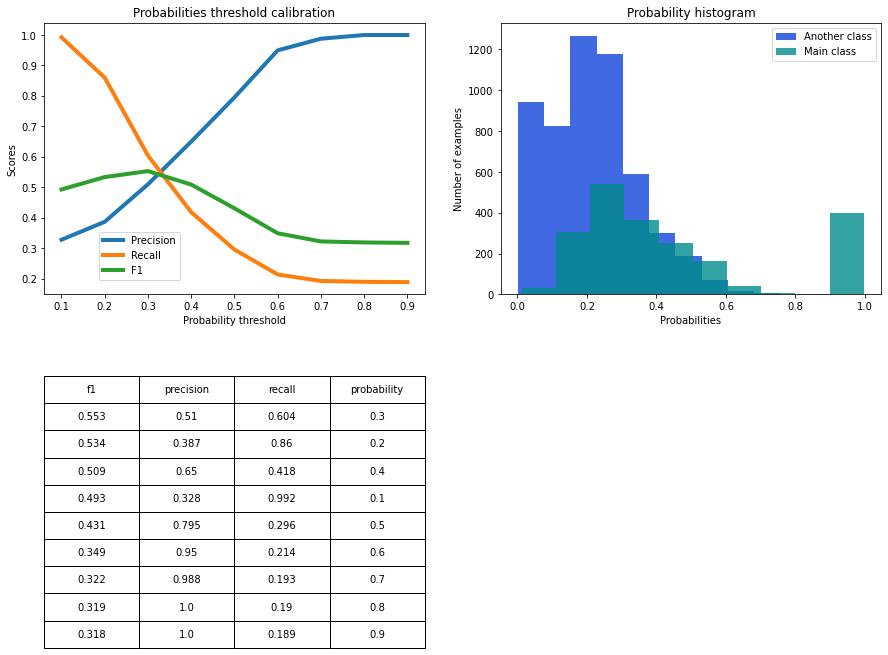

In [134]:
show_proba_calibration_plots(res[4], target)

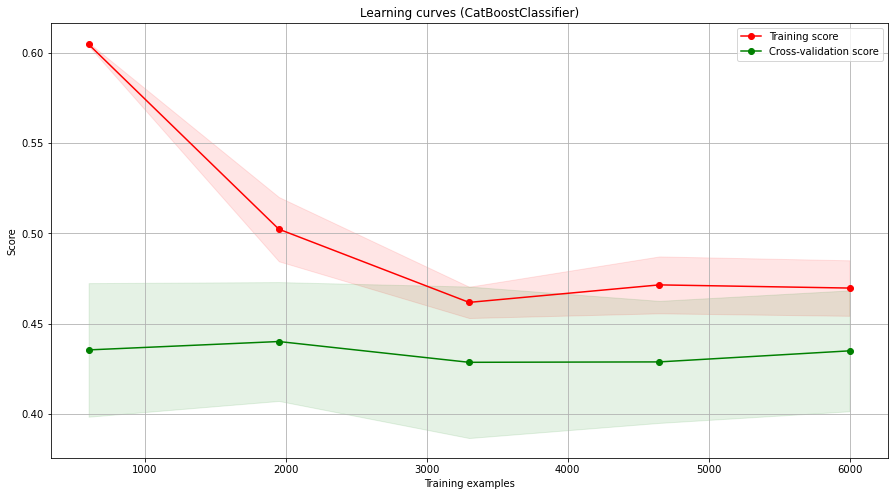

In [135]:
show_learning_curve_plot(model_cb, drop_target(train_work['3-3']), target, cv=5, n_jobs=-1)

In [136]:
bs = get_best_split(res[4], target)
bs

0.26000000000000006

In [153]:
y_train_pred=np.where(y_train_pred<0.33,0,1)
y_test_pred = np.where(res[4]<0.33,0,1)

In [154]:
get_classification_report(target, y_train_pred, target, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.67      0.76      5387
           1       0.48      0.77      0.59      2113

    accuracy                           0.70      7500
   macro avg       0.68      0.72      0.68      7500
weighted avg       0.77      0.70      0.71      7500

TEST

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      5387
           1       0.55      0.54      0.55      2113

    accuracy                           0.75      7500
   macro avg       0.69      0.68      0.69      7500
weighted avg       0.75      0.75      0.75      7500

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               4472   915
1                977  1136


In [676]:
x_train = drop_target(train_work['3-3']).copy()

In [681]:
x_train['Current Loan Amount'] = rankdata(x_train['Current Loan Amount'])

In [961]:
%%time
base_score = np.array([])


for i in range(50):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores = cross_val_score(
        estimator=model_cb,
        X=drop_target(tr),
        y=target,
        scoring='roc_auc',
        cv=fold
    )
    print(scores)
    base_score = np.append(base_score, scores)

[0.76381224 0.77736086 0.78315749 0.77277706 0.7581478 ]
[0.76818762 0.75560581 0.74933883 0.78478664 0.78433209]
[0.75037144 0.78129278 0.7611581  0.79347557 0.77621916]
[0.77717963 0.76446881 0.7451893  0.7924842  0.78203132]
[0.77566768 0.74225676 0.78913852 0.76491623 0.77498011]
[0.7736362  0.77157274 0.77895038 0.75262045 0.77925249]
[0.77772108 0.77171114 0.75952352 0.77311435 0.76686434]
[0.77883044 0.77682549 0.76226255 0.77538954 0.7605167 ]
[0.77310094 0.78577423 0.75882768 0.77034139 0.7597906 ]
[0.7802829  0.76999982 0.79539271 0.75227882 0.77488756]
[0.78020412 0.7772982  0.75059874 0.79017265 0.76295107]
[0.75575262 0.77885269 0.78235176 0.78204785 0.75220822]
[0.77377973 0.74831237 0.77373389 0.77976034 0.77089638]
[0.78583362 0.76024942 0.78659055 0.77048144 0.75214525]
[0.77198723 0.76355944 0.76895339 0.7717421  0.77400422]
[0.78164916 0.76450163 0.74847728 0.7799499  0.79314224]
[0.77406731 0.76047293 0.7596651  0.77056525 0.77735492]
[0.78610886 0.76597759 0.756357

In [962]:
ddd = train_work.copy()
for i in ddd:
    a = categorical_features.copy()
    a.remove('Purpose')
    a.remove( 'Tax Liens')
    if i in ['4-2','5-2','6-2']:
        continue
    ddd[i][categorical_features] =ddd[i][categorical_features].astype('str')
    ddd[i][categorical_features] =ddd[i][categorical_features].astype('str')

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:11:29<00:00, 225.77s/it]

Wall time: 1h 11min 29s


Text(0, 0.5, 't-statistic')

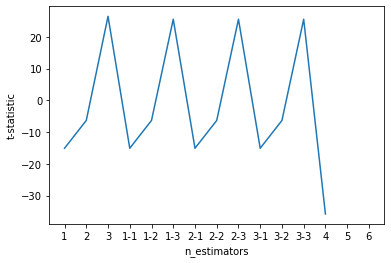

In [963]:
%%time
d = []

for n,i in ddd.items():
    k=i.copy()    

    d.append((n,k))
t_stats, n_trees = [], []
j = 1
for data in tqdm(d):
    current_score = np.array([])
    for i in range(50):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores = cross_val_score(
            estimator=model_cb,
            X=drop_target(data[1]),
            y=target,
            scoring='roc_auc',
            cv=fold,
            n_jobs=-1
        )
        current_score = np.append(current_score, scores)

    t_stat, p_value = ttest_rel(current_score, base_score)
    t_stats.append(t_stat)
    n_trees.append(data[0])

plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

In [958]:
t_stats

[nan,
 -3.190033839833046,
 -1.2179717833926011,
 6.023332744174884,
 -3.190033839833046,
 -1.2179717833926011,
 6.243080111931794,
 -3.190033839833046,
 -1.2179717833926011,
 6.243080111931794,
 -3.190033839833046,
 -1.2179717833926011,
 6.243080111931794,
 -8.691534291647796,
 nan,
 -0.5538322188569391,
 nan,
 nan,
 nan]

In [959]:
n_trees

['start',
 '1',
 '2',
 '3',
 '1-1',
 '1-2',
 '1-3',
 '2-1',
 '2-2',
 '2-3',
 '3-1',
 '3-2',
 '3-3',
 '4',
 '5',
 '6',
 '4-2',
 '5-2',
 '6-2']